In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/6888/as22/fruits-360_dataset.zip /content
!unzip /content/fruits-360_dataset.zip

!pip install datasets
!pip install transformers


Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_290_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_291_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_292_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_293_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_294_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_295_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_296_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_297_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_298_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_299_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_2_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 2/r_300_100.jpg  
  inflating: fruits-360_dat

# Problem 1

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils, initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_path = '/content/fruits-360_dataset/fruits-360'
train_path = base_path + '/Training'
test_path = base_path + '/Test'


BATCH_SIZE = 1000
IMG_SIZE = (75, 75)
SEED = 42


In [20]:
train_gen, valid_gen = tf.keras.utils.image_dataset_from_directory(
    train_path,
    validation_split=0.15,
    subset="both",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_gen = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)


# use cache to improve speed
train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_gen = valid_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_gen = test_gen.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Found 67692 files belonging to 131 classes.
Using 57539 files for training.
Using 10153 files for validation.
Found 22688 files belonging to 131 classes.


In [25]:
from tensorflow.keras.applications import ResNet101, InceptionV3, EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import time
import matplotlib.pyplot as plt


def create_and_train_model(base_model, train_gen, test_gen):

    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add Flatten layer
    x = Flatten()(base_model.output)

    # Modify pre-trained model
    output = Dense(131, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Compile
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model for 50 epochs
    history = model.fit(train_gen, validation_data=valid_gen, epochs=50)


    # Plotting Loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Measure inference time
    start_time = time.time()
    _, accuracy = model.evaluate(test_gen)
    end_time = time.time()
    inference_time = end_time - start_time

    # Get model size (number of parameters)
    num_params = model.count_params()

    return num_params, inference_time, accuracy


## ResNet101

Epoch 1/50
58/58 [==============================] - 16s 175ms/step - loss: 1.0383 - accuracy: 0.8777 - val_loss: 0.0092 - val_accuracy: 0.9973
Epoch 2/50
58/58 [==============================] - 8s 141ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0039 - val_accuracy: 0.9991
Epoch 3/50
58/58 [==============================] - 8s 141ms/step - loss: 2.3212e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9995
Epoch 4/50
58/58 [==============================] - 8s 142ms/step - loss: 1.5769e-04 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 5/50
58/58 [==============================] - 8s 142ms/step - loss: 1.2384e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9995
Epoch 6/50
58/58 [==============================] - 8s 141ms/step - loss: 1.0525e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9996
Epoch 7/50
58/58 [==============================] - 8s 142ms/step - loss: 9.1643e-05 - accuracy: 1.0000 - val_loss: 0.0028 - val_ac

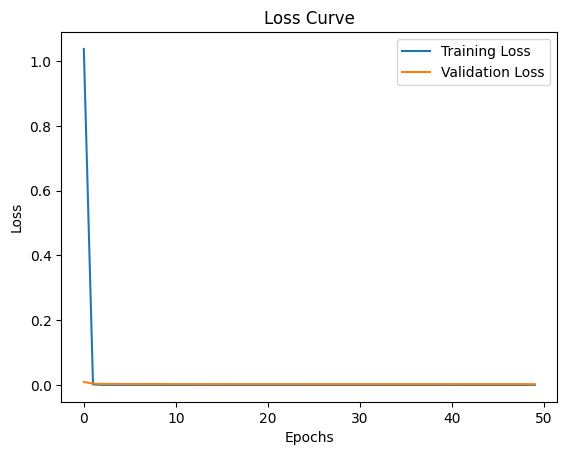

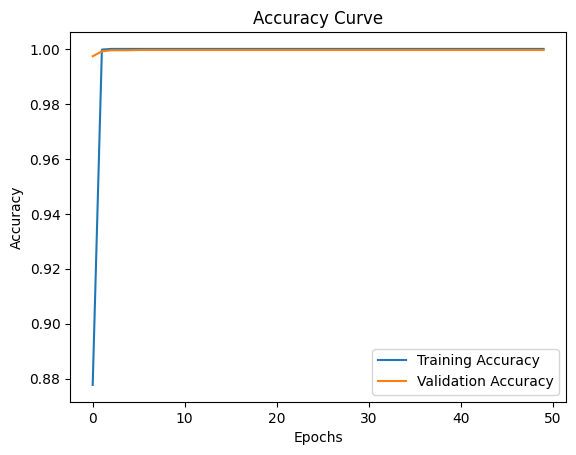

23/23 [==============================] - 3s 123ms/step - loss: 0.3040 - accuracy: 0.9551
ResNet101: Params=45072899, Time=3.25288462638855, Accuracy=0.9550864100456238


In [26]:
# Create and train ResNet101
resnet_base = ResNet101(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
resnet_params, resnet_time, resnet_acc = create_and_train_model(resnet_base, train_gen, test_gen)
print(f"ResNet101: Params={resnet_params}, Time={resnet_time}, Accuracy={resnet_acc}")



## InceptionV3

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/50
58/58 [==============================] - 12s 92ms/step - loss: 28.8679 - accuracy: 0.3771 - val_loss: 5.1887 - val_accuracy: 0.6873
Epoch 2/50
58/58 [==============================] - 3s 48ms/step - loss: 2.9441 - accuracy: 0.7803 - val_loss: 1.6195 - val_accuracy: 0.8350
Epoch 3/50
58/58 [==============================] - 3s 48ms/step - loss: 1.0152 - accuracy: 0.8802 - val_loss: 0.7764 - val_accuracy: 0.8922
Epoch 4/50
58/58 [==============================] - 3s 48ms/step - loss: 0.5639 - accuracy: 0.9180 - val_loss: 0.5188 - val_accuracy: 0.9190
Epoch 5/50
58/58 [==============================] - 3s 48ms/step - loss: 0.3353 - accuracy: 0.9447 - val_loss: 0.3980 - val_accuracy: 0.9365
Epoch 6/50
58/58 [==============================] - 3s 48ms/step - loss: 0.2221 - accuracy: 0.9587 - val_loss: 0.3108 - val_accuracy: 0.9476
Epoch 7/50
58/58 [==============================] - 3s 48ms/step - loss: 0.1622 - accur

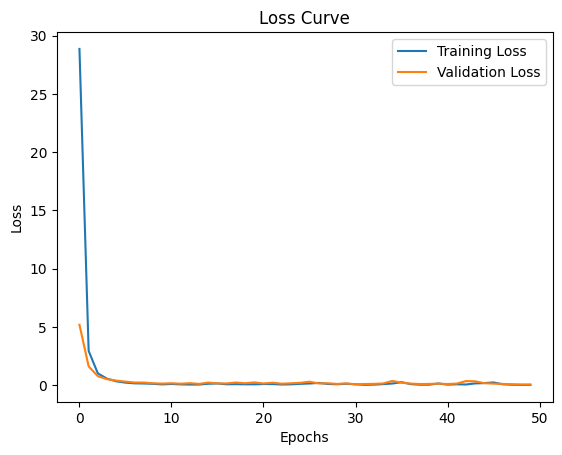

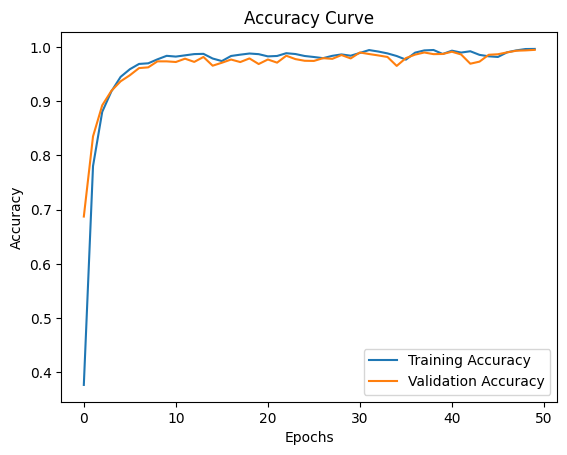

23/23 [==============================] - 2s 76ms/step - loss: 7.0694 - accuracy: 0.7851
InceptionV3: Params=22071203, Time=1.7327241897583008, Accuracy=0.7851287126541138


In [27]:
# Create and train InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
inception_params, inception_time, inception_acc = create_and_train_model(inception_base, train_gen, test_gen)
print(f"InceptionV3: Params={inception_params}, Time={inception_time}, Accuracy={inception_acc}")


## EfficientNetB1

27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/50
58/58 [==============================] - 18s 132ms/step - loss: 0.5713 - accuracy: 0.8776 - val_loss: 0.0406 - val_accuracy: 0.9971
Epoch 2/50
58/58 [==============================] - 6s 95ms/step - loss: 0.0462 - accuracy: 0.9940 - val_loss: 0.0172 - val_accuracy: 0.9992
Epoch 3/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0259 - accuracy: 0.9976 - val_loss: 0.0107 - val_accuracy: 0.9997
Epoch 4/50
58/58 [==============================] - 5s 95ms/step - loss: 0.0180 - accuracy: 0.9986 - val_loss: 0.0080 - val_accuracy: 0.9997
Epoch 5/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0137 - accuracy: 0.9989 - val_loss: 0.0060 - val_accuracy: 0.9999
Epoch 6/50
58/58 [==============================] - 6s 96ms/step - loss: 0.0105 - accuracy: 0.9993 - val_loss: 0.0048 - val_accuracy: 0.9999
Epoch 7/50
58/58 [==============================] - 6s 95ms/step - loss: 0.0081 - accur

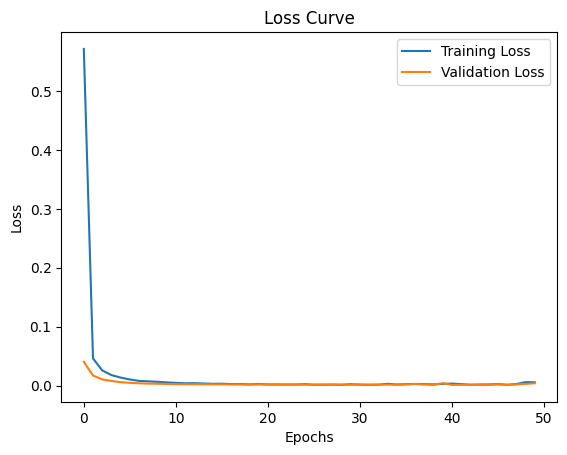

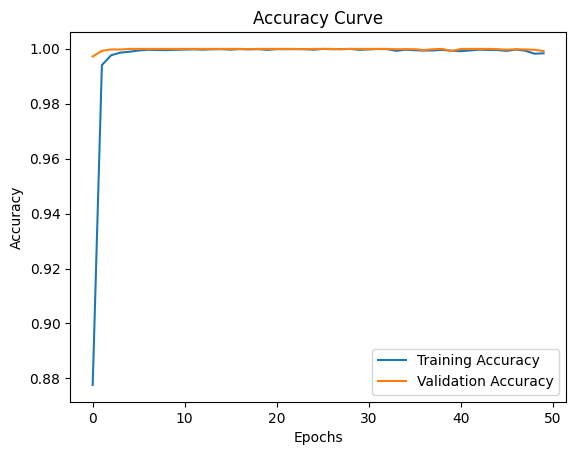

23/23 [==============================] - 2s 81ms/step - loss: 0.1458 - accuracy: 0.9649
EfficientNetB1: Params=8084490, Time=1.8686602115631104, Accuracy=0.9648712873458862


In [28]:
# Create and train EfficientNetB1
effnet_base = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
effnet_params, effnet_time, effnet_acc = create_and_train_model(effnet_base, train_gen, test_gen)
print(f"EfficientNetB1: Params={effnet_params}, Time={effnet_time}, Accuracy={effnet_acc}")

## Discussion

| Model | Dropout rate | Test accuracy |
| --- | --- | --- |
| 1 | 0.1 | 96.7% |
| 1 | 0.3 | 81.2% |
| 1 | 0.5 | 75.2% |
| 2 | 0.3 | 82.1% |

# Problem 2

In [1]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")
train_data = raw_datasets['train'].train_test_split(test_size=1000)['train']
val_data = raw_datasets['train'].train_test_split(test_size=1000)['test']
test_data = raw_datasets['test']



In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")


In [3]:
from transformers import AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader

def tokenize_batch(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

train_data = train_data.map(tokenize_batch, batched=True)
val_data = val_data.map(tokenize_batch, batched=True)
test_data = test_data.map(tokenize_batch, batched=True)

train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


training_args = TrainingArguments(
    per_device_train_batch_size=128,
    learning_rate=1e-5,
    weight_decay=0.01,
    num_train_epochs=10,
    logging_dir='./logs',
    output_dir='./results'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data
)

trainer.train()


Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

OutOfMemoryError: ignored

In [ ]:
input_text = "This movie was really amazing!"
tokens = tokenizer(input_text, padding=True, truncation=True, return_tensors="tf")
output = model(tokens)
